In [3]:
import os
import numpy as np
import mne
from scipy.stats import zscore
import pandas as pd

eeg_raw_data_dir = (
    "C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data"
)

all_channels_psds = {}  # Will be of length 62 as this is max channels

smallest_ch_samples = 74255  # precalculated
observed_freq_cap = 80
n_fft = 2048

metadata = pd.read_csv("eeg_metadata.csv")

# Filter subject IDs based on the 'Study' column
schizophrenia_subjects = metadata[metadata["Study"] == "Proband with Schizophrenia"][
    "SubjectID"
].tolist()
healthy_controls = metadata[metadata["Study"] == "Healthy Control"][
    "SubjectID"
].tolist()

skipped = []


def gen_emp_psd(eeg_freq):
    for filename in os.listdir(eeg_raw_data_dir):

        subject_id = int(filename.split("_", 5)[4])

        # Add filter here, depending on which subject group you want to generate the PSD for
        # Make sure to change the name saved too
        if (subject_id) in healthy_controls:
            continue  # Skip to next iteration

        eeg_path = os.path.join(eeg_raw_data_dir, filename)
        raw = mne.io.read_raw_fif(eeg_path, preload=True)

        # In order to average spectra, must have stationary signal, so z-score signals first
        data = raw.get_data()  # shape is (n_channels, n_samples)
        data = zscore(data, axis=1)

        # Exclude non-EEG channels
        exclude_channels = ["CB1", "CB2", "VEO", "HEO", "EKG", "EMG"]
        filtered_ch_names = [
            ch_name for ch_name in raw.ch_names if ch_name not in exclude_channels
        ]

        # Compute PSD using Welch's method for each channel
        for ch_idx, ch_name in enumerate(filtered_ch_names):

            ch_data = data[ch_idx, :]  # Get data for the specific channel

            psd, freqs = mne.time_frequency.psd_array_welch(
                ch_data,
                sfreq=eeg_freq,
                fmin=0,
                fmax=80,
                n_fft=n_fft,
                n_overlap=n_fft // 2,
                window="hamming",
            )

            if ch_name in all_channels_psds:
                all_channels_psds[ch_name].append(psd)
            else:
                all_channels_psds[ch_name] = [psd]

    # Average PSDs across all subjects for each channel
    for ch_name in filtered_ch_names:
        stacked_psds = np.stack(all_channels_psds[ch_name])
        avg_psd = np.mean(stacked_psds, axis=0)
        all_channels_psds[ch_name] = avg_psd

    # Combine the averaged PSDs into a single array
    # Shape (62, freq_samples)
    emp_psd = np.stack(list(all_channels_psds.values()))

    # Save the average spectrum
    np.save("emp_spec_schiz.npy", emp_psd)
    return freqs

In [4]:
freqs = gen_emp_psd(1000)

Opening raw data file C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data\filt_chanrej_SASICA_MARA_0332_042410_RestEyesClosed_RS_1_preprocessed-raw.fif...
    Range : 0 ... 282238 =      0.000 ...   282.238 secs
Ready.
Reading 0 ... 282238  =      0.000 ...   282.238 secs...
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 

In [5]:
emp_spec_schiz = np.load("emp_spec_schiz.npy")
emp_spec_control = np.load("emp_spec_control.npy")

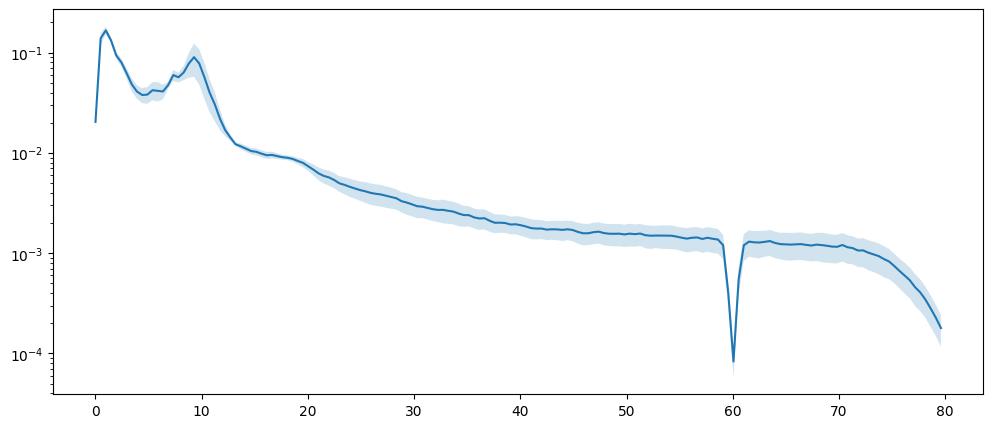

In [20]:
import matplotlib.pyplot as plt

# Calculate mean and standard deviation
mean_spectrum = emp_spec_schiz.mean(axis=0)
std_spectrum = emp_spec_schiz.std(axis=0)

plt.figure(figsize=(12, 5))

plt.semilogy(freqs, mean_spectrum, label='Mean Spectrum')
plt.fill_between(freqs, mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, alpha=0.2, label='Standard Deviation')

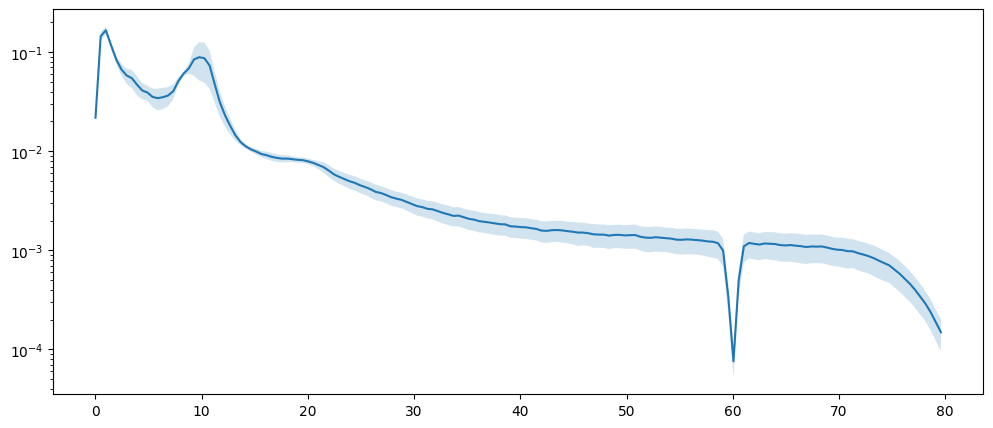

In [22]:

plt.figure(figsize=(12, 5))
# Calculate mean and standard deviation
mean_spectrum_control = emp_spec_control.mean(axis=0)
std_spectrum_control = emp_spec_control.std(axis=0)

plt.semilogy(freqs, mean_spectrum_control, label='Mean Spectrum')
plt.fill_between(freqs, mean_spectrum_control - std_spectrum_control, mean_spectrum_control + std_spectrum_control, alpha=0.2, label='Standard Deviation')

In [24]:
%run Jansen_And_Rit.py
x1, x2, x3, V_T_sim = run_jansen_and_rit(6, 33, 181, 50, 33, 24, 0.86683738581593, 0.5852094063636971, 0.07176133509757855, 0.05239191241809195, 0.06200735558239091)

# Change this depending on what dataset optimising for
emp_spec = np.load("emp_spec_schiz.npy", allow_pickle=True)


KeyboardInterrupt: 

In [23]:
gen_data = V_T_sim.T
fake_info = mne.create_info(62, sfreq=1000, ch_types="eeg")
gen_raw = mne.io.RawArray(gen_data, fake_info)
gen_spec = gen_raw.compute_psd(fmin=0, fmax=80, picks="all")
gen_spec.plot(average=True)

NameError: name 'V_T_sim' is not defined